In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

import sys
sys.path.append('../')
from methods import permutation_test, Hexagon
from models import JitterCI, JacobianCI
from plotting_functions import set_size, colorbar_axis
from utils import rotation_matrix

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = True
dpi=150

In [4]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    metric_history = np.array(metric_history)
    phases_history = np.array(phases_history)
    G_history = np.array(G_history)
    return loss_history, phases_history, metric_history, G_history

def hex_radius(phases, model):
    cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
    off_diag_mask = ~np.eye(cdists.shape[0],dtype=bool)
    return np.mean(cdists[off_diag_mask]), np.std(cdists[off_diag_mask])

def hex_orientation(phases, model, degrees=True):
    # mirror x and y since arctan2 takes y as first argument and x as second
    angles = np.stack([np.arctan2(*(model.unit_cell.wrap(phases - phases[i]))[:,::-1].T) 
                       for i in range(len(phases))])
    # modulo 60 degrees
    angles = angles % (np.pi/3)
    angles = angles * 180/np.pi if degrees else angles
    off_diag_mask = ~np.eye(phases.shape[0],dtype=bool)
    return np.mean(angles[off_diag_mask]), np.std(angles[off_diag_mask]) 

In [5]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history, phases_history, metric_history, G_history = train_model(model)

100%|██████████| 5000/5000 [00:12<00:00, 406.88it/s]


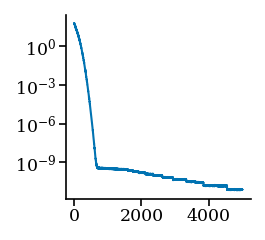

In [6]:
plt.semilogy(loss_history)

(-0.7333333333333333,
 0.7333333333333333,
 -0.6350852961085885,
 0.6350852961085884)

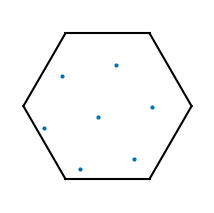

In [7]:
fig,ax = model.unit_cell.plot(color='black')
ax.scatter(*phases_history[-1].T,s=1)
ax.axis('equal')
ax.axis('off')

In [8]:
phases_history_short = phases_history[::25]
phases_history_short = np.array([model.unit_cell.wrap(phases_history_short[i]) for i in range(len(phases_history_short))])

radius, _ = hex_radius(phases_history[-1],model)
orientation, _ = hex_orientation(phases_history[-1],model)
center = np.mean(phases_history[-1],axis=0)
metagon = Hexagon(radius, orientation, center)
orientation

10.893394649130874

(-0.7333333333333333,
 0.7333333333333333,
 -0.6350852961085885,
 0.6350852961085884)

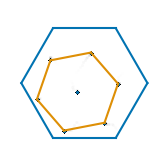

In [9]:
figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

N = len(phases_history_short)
[ax.scatter(*phases_history_short[i].T,color='black',alpha=(i+0.7)/(N+0.7)) for i in range(N)]
ax.scatter(*phases_history[-1].T)
model.unit_cell.plot(fig,ax,color=color_cycler[0])
metagon.plot(fig,ax,color=color_cycler[1])

ax.axis('off')
ax.axis('equal')

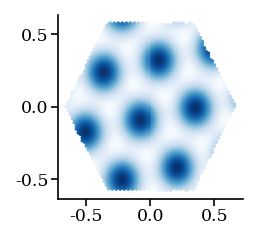

In [10]:
kde, mesh, kernel, expanded_phases = model.phase_kde(bw_method=0.1)
plt.scatter(*mesh.T, c=kde, s=0.5)

In [11]:
import copy 

nperms = 40
#stds = np.linspace(0.02, 0.1, 3)
stds = [0.01, 0.05, 0.15]
ball_radii = np.linspace(0, model.unit_cell.radius, 21)[1:]
ripleys = np.zeros((nperms, len(stds), len(ball_radii)))
phases_multiple = 15
for i in tqdm.trange(nperms):
    for j in range(len(stds)):
        tmp_phases = model.phases.detach().numpy()[:,None] + np.random.normal(0, stds[j], size=(phases_multiple,2))[None]
        tmp_phases = tmp_phases.reshape(-1,2)
        tmp_phases = model.unit_cell.wrap(tmp_phases)
        tmp_model = copy.deepcopy(model)
        tmp_model.set_phases(tmp_phases)
        tmp_model.set_scale()
        for k in range(len(ball_radii)):
            ripley = tmp_model.ripleys(ball_radii[k])
            ripleys[i,j,k] = ripley
ripleys = np.array(ripleys)

100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


In [12]:
ripleys_random_uniform = np.zeros((nperms, len(ball_radii)))
for i in tqdm.trange(nperms):
    tmp_phases = model.phases.detach().numpy()[:,None] + model.unit_cell.sample(15)[None]
    tmp_phases = tmp_phases.reshape(-1,2)
    tmp_phases = model.unit_cell.wrap(tmp_phases)
    tmp_model = copy.deepcopy(model)
    tmp_model.set_phases(tmp_phases)
    tmp_model.set_scale()
    for j in range(len(ball_radii)):
        tmp_ripley = tmp_model.ripleys(ball_radii[j])
        ripleys_random_uniform[i,j] = tmp_ripley
ripleys_random_uniform = np.array(ripleys_random_uniform)

100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


In [13]:
ripleys_random = np.zeros((nperms, len(ball_radii)))
for i in tqdm.trange(nperms):
    tmp_phases = model.unit_cell.sample(15*model.ncells)
    tmp_model = copy.deepcopy(model)
    tmp_model.set_phases(tmp_phases)
    tmp_model.set_scale()
    for j in range(len(ball_radii)):
        tmp_ripley = tmp_model.ripleys(ball_radii[j])
        ripleys_random[i,j] = tmp_ripley
ripleys_random = np.array(ripleys_random)

100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


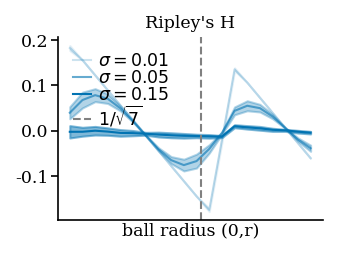

In [14]:
figsize = set_size(fraction=(0.9/2,1/3),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

alphas = [0.2, 0.6, 1.0]
for j in range(ripleys.shape[1]):
    ax.plot(ball_radii, np.mean(ripleys,axis=0)[j], alpha=alphas[j], color=color_cycler[0], label=r'$\sigma={}$'.format(stds[j]))
    ax.fill_between(ball_radii, np.mean(ripleys,axis=0)[j]-np.std(ripleys,axis=0)[j],
                        np.mean(ripleys,axis=0)[j]+np.std(ripleys,axis=0)[j], alpha=0.5*alphas[j], color=color_cycler[0])
ax.axvline(1/np.sqrt(7), color='grey', linestyle='--', label=r'$1/\sqrt{7}$')
ax.legend(loc='upper left')

ax.set_xlabel('ball radius ' + r'(0,r)', fontsize='small')
ax.set_title("Ripley's H", fontsize='small')
ax.set_xticks([])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-ripleys-sup1')

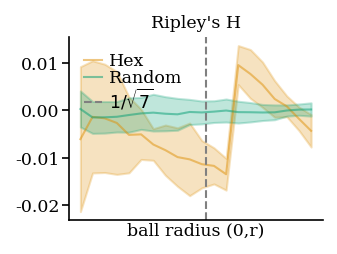

In [15]:
figsize = set_size(fraction=(0.9/2,1/3),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

ax.plot(ball_radii, np.mean(ripleys_random_uniform,axis=0), alpha=0.5, color=color_cycler[1], label='Hex')
ax.fill_between(ball_radii, np.mean(ripleys_random_uniform,axis=0)-np.std(ripleys_random_uniform,axis=0),
                    np.mean(ripleys_random_uniform,axis=0)+np.std(ripleys_random_uniform,axis=0), alpha=0.25, color=color_cycler[1])
ax.plot(ball_radii, np.mean(ripleys_random,axis=0), alpha=0.5, color=color_cycler[2], label='Random')
ax.fill_between(ball_radii, np.mean(ripleys_random,axis=0)-np.std(ripleys_random,axis=0),
                    np.mean(ripleys_random,axis=0)+np.std(ripleys_random,axis=0), alpha=0.25, color=color_cycler[2])
ax.axvline(1/np.sqrt(7), color='grey', linestyle='--', label=r'$1/\sqrt{7}$')
ax.legend(loc='upper left')

ax.set_xlabel('ball radius ' + r'(0,r)', fontsize='small')
ax.set_title("Ripley's H", fontsize='small')
ax.set_xticks([])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-ripleys-sup2')